In [1]:
import pandas as pd
import time, datetime, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle, utils

In [122]:
tini, tend = datetime.datetime(2024, 8, 1, 3, 0, 0), datetime.datetime(2024, 8, 10, 9, 0, 0)
data, data_err = utils.load_data(tini, tend)

Text(0, 0.5, 'Current (mA)')

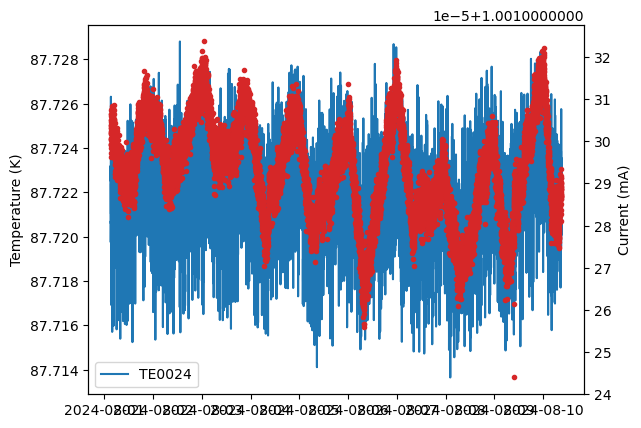

In [125]:
channel = "TE0024"
fig, axes = plt.subplots(1,1)
axes2 = axes.twinx()

conditions = (data[channel]<90)&(data[channel]>87)

axes.plot(data.loc[conditions].index.to_numpy(), data.loc[conditions][channel].to_numpy(), label=channel)
axes.set_ylabel("Temperature (K)")
axes.legend(loc="lower left")
axes2.plot(data.loc[conditions].index.to_numpy(), data.loc[conditions]["IE_Card01"].to_numpy(), ".", color="tab:red")
axes2.set_ylabel("Current (mA)")


In [126]:
import lmfit
import matplotlib.pyplot as plt

# Define the line model
def line(x, A, B):
    return A + B * x

downsampling_time = "10min"
mapping = utils.load_mapping(date=datetime.datetime(2024, 8, 1, 0, 0, 0))

container = {}
for channel in data.columns:
    try:
        channel_N = int(channel.split("TE")[1])
    except:
        continue
    if channel_N > 96:
        break
    conditions = (data.resample(downsampling_time).mean()[channel] < 90) & (data.resample(downsampling_time).mean()[channel] > 85)
    mapping_row = mapping.loc[(mapping["SC-ID"]==channel)]
    try:
        board = int(mapping_row["BOARD"].iloc[0])
    except:
        continue
    current_name = fr"IE_Card0{board}"
    try:
        x_data = data.resample(downsampling_time).mean().loc[conditions][current_name].to_numpy() - data.resample(downsampling_time).mean().loc[conditions][current_name].mean()
        y_data = data.resample(downsampling_time).mean().loc[conditions][channel].to_numpy()

        x_err = data.resample(downsampling_time).std().loc[conditions][current_name].to_numpy()
        y_err = data.resample(downsampling_time).std().loc[conditions][channel].to_numpy()

        line_model = lmfit.Model(line)
        params = line_model.make_params(A=0, B=1)
        weights = 1 / (x_err**2 + y_err**2)
        fit_result = line_model.fit(y_data, params, x=x_data, weights=weights)
        container[channel_N] = {"value":fit_result.params["B"].value, "err":fit_result.params["B"].stderr}
    except:
        continue


(-0.5, 96.5)

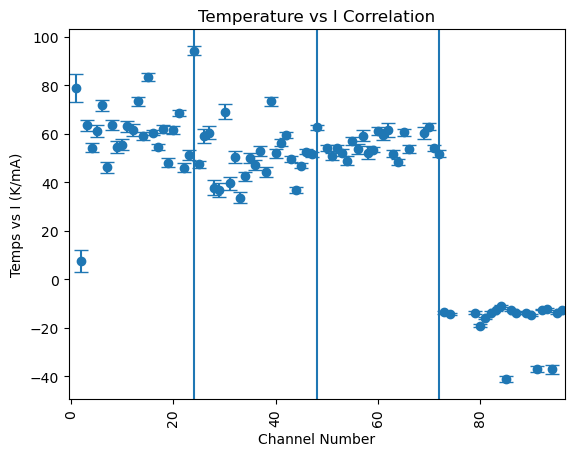

In [127]:
res = pd.DataFrame(container).T
plt.errorbar(res.index.to_numpy(), res["value"].to_numpy(), yerr=res["err"].to_numpy(), fmt="o", capsize=5)
plt.ylabel("Temps vs I (K/mA)")
plt.xlabel("Channel Number")
plt.xticks(rotation=90);
plt.axvline(24)
plt.axvline(48)
plt.axvline(72)
plt.title("Temperature vs I Correlation")
plt.xlim(-0.5, 96.5)